## Create Dataset

In [1]:
from lib.data_loader import PointCloudDataset
from torch.utils.data import DataLoader

In [2]:
point_cloud_dataset = PointCloudDataset(8) #8480
dataloader = DataLoader(point_cloud_dataset, batch_size=8, shuffle=True)

## Variational Auto encoder

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [43]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1     = nn.Conv1d(3, 64, 1)
        self.conv2     = nn.Conv1d(64, 128, 1)
        self.conv3     = nn.Conv1d(128, 256, 1)
        self.conv4     = nn.Conv1d(256, 512, 1)
        self.conv5_1   = nn.Conv1d(512, 256, 1)
        self.conv5_2   = nn.Conv1d(512, 256, 1)
        self.maxPool1d = nn.MaxPool1d(2048)
        
        self.relu   = nn.ReLU()
        self.bn1    = nn.BatchNorm1d(64) 
        self.bn2    = nn.BatchNorm1d(128) 
        self.bn3    = nn.BatchNorm1d(256)
        self.bn4    = nn.BatchNorm1d(512) 
        self.bn5_1  = nn.BatchNorm1d(256)
        self.bn5_2  = nn.BatchNorm1d(256)

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        
        x_1 = self.relu(self.bn5_1(self.conv5_1(x)))
        x_1 = torch.max(x_1, 2, keepdim=True)[0]
        x_2 = self.relu(self.bn5_2(self.conv5_2(x)))
        x_2 = torch.max(x_2, 2, keepdim=True)[0]
        
        return x_1, x_2

Encoder()

Encoder(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (conv5_1): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (conv5_2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (maxPool1d): MaxPool1d(kernel_size=2048, stride=2048, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [44]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2048*3)

        self.relu = nn.ReLU()
        self.bn1  = nn.BatchNorm1d(256) 
        self.bn2  = nn.BatchNorm1d(256) 
        
    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = x.view(-1, 3, 2048)
        
        return x
    
Decoder()

Decoder(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6144, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [45]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps if self.training else mu

    def forward(self, x):

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Training

In [55]:
from lib.chamfer_kl import ChamferKLLoss
from lib.callbacks import EarlyStopping

model = VAE()
model.training = True

chamfer_kl_loss = ChamferKLLoss()

early_stopping = EarlyStopping(patience=1000)

num_epochs = 800
learning_rate = 0.005 #1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=5.0, momentum=0.9)

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(num_epochs):
    
    if epoch == 0:
        early_stopping.on_train_begin()

    running_loss = 0.0
    
    for data in dataloader:

        data = data.float()
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        train_output, mu, logvar = model(data)
        
        loss = chamfer_kl_loss(train_output, data, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data  
    
    if early_stopping.on_epoch_end(epoch + 1, running_loss):
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, running_loss))
        print('Terminated Training for Early Stopping at Epoch %04i' % (epoch + 1))
        break
        
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, running_loss))

epoch [1/800], loss:7751.7100
epoch [20/800], loss:298.3854
epoch [40/800], loss:217.0086
epoch [60/800], loss:140.6191
epoch [80/800], loss:128.7013
epoch [100/800], loss:106.4697
epoch [120/800], loss:82.6848
epoch [140/800], loss:86.1441
epoch [160/800], loss:81.3706
epoch [180/800], loss:61.5896
epoch [200/800], loss:66.1741
epoch [220/800], loss:60.8371
epoch [240/800], loss:57.9721
epoch [260/800], loss:60.7729
epoch [280/800], loss:60.8190
epoch [300/800], loss:58.6374
epoch [320/800], loss:58.3716
epoch [340/800], loss:57.1021
epoch [360/800], loss:57.4381
epoch [380/800], loss:55.9891
epoch [400/800], loss:57.5315
epoch [420/800], loss:55.9889
epoch [440/800], loss:55.3923
epoch [460/800], loss:56.0678
epoch [480/800], loss:58.1431
epoch [500/800], loss:57.4409
epoch [520/800], loss:55.7842
epoch [540/800], loss:55.1895
epoch [560/800], loss:55.7730
epoch [580/800], loss:56.0574
epoch [600/800], loss:56.0109
epoch [620/800], loss:54.6364
epoch [640/800], loss:55.2829
epoch [66

#### save

In [56]:
torch.save(model.encoder.state_dict(), './models/encoder_tmp.pt')
torch.save(model.decoder.state_dict(), './models/decoder_tmp.pt')

### get input values for validation

In [57]:
train_input  = next(iter(dataloader)).float()

if torch.cuda.is_available():
    train_output, _, _ = model(train_input.cuda())
    train_output = train_output.cpu()
else:
    train_output, _, _ = model(train_input)

In [58]:
v_encoder = Encoder()
v_decoder = Decoder()

v_encoder.load_state_dict(torch.load('./models/encoder_tmp.pt'))
v_decoder.load_state_dict(torch.load('./models/decoder_tmp.pt'))

## Generator

In [59]:
class Generator(VAE):
    
    def __init__(self, encoder, decoder):
        super(Generator, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.training = False

    def forward(self, x):

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        
        return self.decoder(z)

In [60]:
generator = Generator(v_encoder, v_decoder)
generator_output = generator(train_input)

## Validation

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

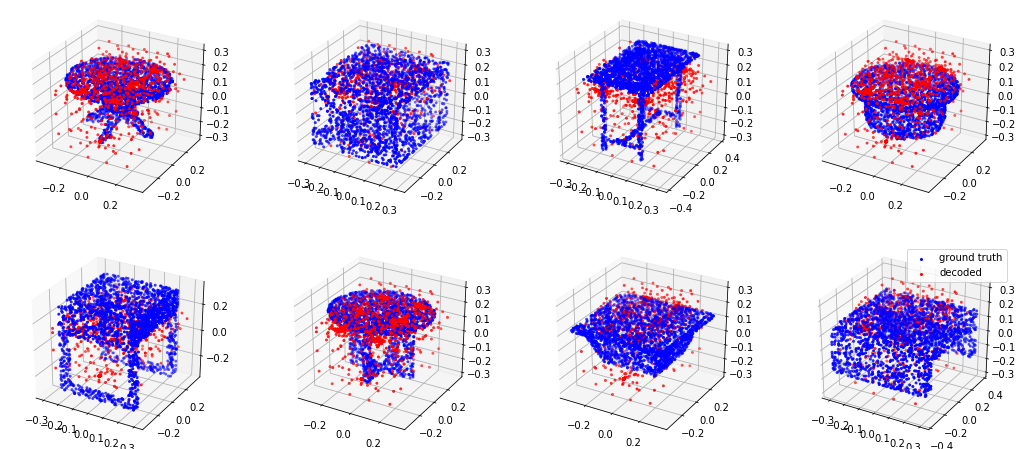

In [62]:
fig = plt.figure(figsize=(18, 8))

for i in range(8):
    
    row, columns, num = 2, 4, i + 1
    ax = fig.add_subplot(row, columns, num, projection='3d')

    data = train_input[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='b', label='ground truth')

    data = train_output[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='r', label='decoded')

#     data = generator_output[i].detach().numpy()
#     ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='g', label='decoded & modified')

ax.legend()
plt.show()

In [63]:
for i in range(8):
    d1 = train_input[i].detach().numpy()
    d2 = train_output[i].detach().numpy()
    print(np.sum(abs(d1 - d2)))

956.83856
1298.7166
1112.0388
1109.8748
1252.6948
1008.2622
1117.7183
1243.0957


In [16]:
# for i in range(8):
#     d1 = train_input[i]
#     d2 = train_output[i]
#     print(criterion(d1.reshape(1, 3, 2048), d2.reshape(1, 3, 2048)).data)

## Write to File

In [17]:
def write(points, file_name, directory='./output/'):
    
    if points.shape[0] < points.shape[1] and points.shape[0] == 3:
        points = points.T
    
    with open(directory + file_name, 'w') as f:
        
        f.write(str(points.shape[0]) + '\n')

        for pt in points:
            f.write('%.8f %.8f %.8f\n' % tuple(pt))
    
write(next(iter(dataloader))[2].detach().numpy(), 'point_cloud.txt', '../pointcloud2mesh/mount/')

## TODOs

* Manimulate latent vector or try something else to generate more nice tables
* Reduce the number of point clouds or connect each points reasonably

## Misc

In [18]:
input = torch.randn(10, 2048, 3)
print(input.shape)
m = nn.Conv1d(2048, 256, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(256, 128, 1)
output = m(output)
m = nn.Conv1d(128, 64, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(64, 32, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(3)
output = m(output)
print(output.shape)

torch.Size([10, 2048, 3])
torch.Size([10, 256, 3])
torch.Size([10, 64, 3])
torch.Size([10, 32, 3])
torch.Size([10, 32, 1])


In [19]:
input = torch.randn(10, 3, 2048)
print(input.shape)
m = nn.Conv1d(3, 64, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(64, 128, 1)
output = m(output)
m = nn.Conv1d(128, 256, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(256, 512, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(2048) # output = torch.max(output, 2, keepdim=True)[0]
output = m(output)
print(output.shape)

torch.Size([10, 3, 2048])
torch.Size([10, 64, 2048])
torch.Size([10, 256, 2048])
torch.Size([10, 512, 2048])
torch.Size([10, 512, 1])


In [20]:
class TmpLoss(nn.Module):

    # https://github.com/345ishaan/DenseLidarNet/blob/master/code/chamfer_loss.py
    def __init__(self):
        super(TmpLoss, self).__init__()
        self.use_cuda = torch.cuda.is_available()        

    def forward(self,preds,gts):
        P = self.batch_pairwise_dist(gts, preds)
        mins, _ = torch.min(P, 1)
        loss_1 = torch.sum(mins)
        mins, _ = torch.min(P, 2)
        loss_2 = torch.sum(mins)
        return loss_1 + loss_2

    def batch_pairwise_dist(self,x,y):
        x = x.transpose(2, 1)
        y = y.transpose(2, 1)
        _, num_points_x, _ = x.size()
        _, num_points_y, _ = y.size()
        xx = torch.bmm(x, x.transpose(2,1))
        yy = torch.bmm(y, y.transpose(2,1))
        zz = torch.bmm(x, y.transpose(2,1))
        if self.use_cuda:
            dtype = torch.cuda.LongTensor
        else:
            dtype = torch.LongTensor
        diag_ind_x = torch.arange(0, num_points_x).type(dtype)
        diag_ind_y = torch.arange(0, num_points_y).type(dtype)
        rx = xx[:, diag_ind_x, diag_ind_x].unsqueeze(1).expand_as(zz.transpose(2,1))
        ry = yy[:, diag_ind_y, diag_ind_y].unsqueeze(1).expand_as(zz)
        P = (rx.transpose(2,1) + ry - 2*zz)
        return P

In [21]:
input = Variable(torch.ones(2, 3, 12))
output = Variable(torch.zeros(2, 3, 12))
ls = TmpLoss()
ls.forward(input, output)

tensor(144.)

In [22]:
xx = torch.bmm(input, input.transpose(2,1))
xx.shape

torch.Size([2, 3, 3])

In [23]:
input.transpose(2,1)

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

In [24]:
! docker exec cgal /DeepTable/pointcloud2mesh/build/pointcloud2mesh.out ./mount/point_cloud.txt ./mount/output.off

./mount/point_cloud.txt
./mount/output.off
2048 points read
Delaunay computed.
Alpha shape computed in REGULARIZED mode by defaut.
Smallest alpha value to get a solid through data points is 0.00435654
Optimal alpha value to get one connected component is 0.0147552
OFF 8346 2782 0
-0.132913 0.286431 -0.247802
-0.14257 0.281131 -0.240646
-0.140252 0.286082 -0.211281
-0.132913 0.286431 -0.247802
-0.140252 0.286082 -0.211281
-0.128491 0.286452 -0.240958
-0.122015 -0.278137 -0.209186
-0.133631 -0.281501 -0.218859
-0.135623 -0.280901 -0.252189
-0.123145 -0.265327 -0.252889
-0.135623 -0.280901 -0.252189
-0.142226 -0.277736 -0.24451
-0.123145 -0.265327 -0.252889
-0.142226 -0.277736 -0.24451
-0.124676 -0.262075 -0.245846
-0.123028 0.285361 -0.137018
-0.126765 0.286761 -0.132432
-0.0678598 0.280358 -0.164654
-0.13291 0.283415 -0.254948
-0.132913 0.286431 -0.247802
-0.121745 0.282569 -0.251399
-0.142474 -0.277233 -0.223736
-0.142226 -0.277736 -0.24451
-0.140851 -0.280048 -0.228324
-0.142474 -0.27

In [25]:
def load_file(file_name):
    vertices = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            vals = line.split(' ')
            if i > 2 and len(vals) == 3:
                vertex = [float(vals[0]), float(vals[1]), float(vals[2])]
                vertices.append(np.array(vertex))

    return np.random.permutation(np.array(vertices))[:2048]

lines = load_file('../pointcloud2mesh/mount/output.off')
pts.shape
# trace = go.Mesh3d(x=x,y=y,z=z,color='#FFB6C1',opacity=0.50)
# py.iplot([trace])

NameError: name 'pts' is not defined